# Tutorial
This guide explains how to use **ionBench**. It gives practical advice on setting up and editing problems classes and running optimisers. If you want more theoretical information, such as what the performance metrics are, check out the **introduction**.

In [1]:
import ionbench
import numpy as np
import os

## Benchmarkers and Test Problems
Each of the benchmarker problem classes are loaded in a similar way. They may take a few seconds to initialise while they compile the Myokit simulation objects to run the models. Typically, you would only need one benchmarker at once, here we will use the staircase Hodgkin-Huxley benchmarker, but the functions to load the other benchmarkers are shown below, just commented out.

In [2]:
hh = ionbench.problems.staircase.HH()
# mm = ionbench.problems.staircase.MM()
# ikr = ionbench.problems.loewe2016.IKr()
# ikur = ionbench.problems.loewe2016.IKur()
# ina = ionbench.problems.moreno2016.INa()

Initialising Hodgkin-Huxley IKr benchmark
Benchmarker initialised


### Sampling Parameters
Now that we have a problem initialised, we can take a look at some of the functions we can use with it.
The `.sample()` method will randomly sample a set of parameters in a region defined for each problem. This is the main method for generating parameters. The sample method for each function also has an optional input `n`. This allows you to generate more than one parameter vector, returning a list of parameter vectors.

In [3]:
print('Sampled parameters: ')
print(hh.sample())
print('Sampling more than one parameter vector:')
print(hh.sample(n=3))

Sampled parameters: 
[8.13441954e-06 1.98113696e-01 1.33855751e-02 1.87667087e-02
 1.37266965e-07 3.28452991e-01 4.82009847e-07 1.02899418e-01
 4.62973771e-02]
Sampling more than one parameter vector:
[array([1.39426294e-02, 5.93973056e-02, 3.85369056e-03, 8.06044927e-02,
       8.97993685e-04, 1.07478345e-01, 1.93367474e-05, 1.72241154e-02,
       9.54871908e-02]), array([2.89720290e-03, 7.76566118e-02, 1.02928373e-05, 1.26903856e-01,
       2.14436968e-07, 8.83204046e-02, 2.40140082e-05, 1.45116473e-01,
       8.47472849e-02]), array([1.49068960e-07, 3.15766496e-01, 1.46423537e-05, 8.08163190e-02,
       3.63301500e-01, 6.82866942e-02, 8.90911918e-04, 9.54385950e-02,
       4.06730375e-02])]


### Cost Functions
Now that we have seen how to sample parameters, we can use the benchmarker to see how good sampled parameter are. 
Each benchmarker has a `.cost(param)` method which takes an input of a set of parameters and will simulate the model with those parameters, compare against the data stored in `hh.data` and calculate the RMSE.

In [4]:
param = hh.sample()
print('Sampled parameters:')
print(param)
print('Cost of sampled parameters:')
print(hh.cost(param))

Sampled parameters:
[3.21500685e+00 3.78733201e-02 7.35437576e+01 1.05827992e-02
 6.14812368e-06 2.94766813e-01 2.24701207e-01 4.84113872e-02
 1.31454078e-01]
Cost of sampled parameters:
0.5522137111808383


Sometimes we don't want to know the RMSE cost and instead want a vector of residuals. There are methods in the benchmarker for exactly this, providing both residuals and squared residuals. These are sometimes required by certain optimisers such as scipy's least squares optimisers.

In [5]:
print('Residuals of sampled parameters:')
print(hh.signed_error(param))
print('Squared residuals of sampled parameters:')
print(hh.squared_error(param))

Residuals of sampled parameters:
[-0.00267373 -0.01115909  0.01181726 ... -0.0303321   0.00667567
 -0.00461445]
Squared residuals of sampled parameters:
[7.14880838e-06 1.24525319e-04 1.39647747e-04 ... 9.20036052e-04
 4.45646290e-05 2.12931168e-05]


We ran into a warning here. This is because we evaluated the cost of `param` in the previous cell and then evaluated the `signed_error(param)` in this cell. Since this required us to solve the model twice for the same parameters, we could have been more efficient by first finding `signed_error(param)` and then calculating the cost from its result. ***ionBench*** will track which parameters are used to solve the model and warn you if its thinks your optimisation is inefficient. Since we are just running a tutorial, we can ignore this warning, but it is something to be aware of when running optimisations.

### Helper Functions
There are also some other generally useful functions in the benchmarkers. Each benchmarker has a function which returns the number of parameter in its model, called `.n_parameters()`. Each benchmarker also stores a name attribute under `.NAME`. Try to keep the use of `.NAME` as limited as possible (as optimisers doing something problem-specific can lead to biases), but sometimes it may be necessary to include problem-specific features, for example, the modifications use `.NAME` to identify the bounds for the sampler.

In [6]:
print('Number of parameter in the model:')
print(hh.n_parameters())
print('Name of the benchmarker:')
print(hh.NAME)

Number of parameter in the model:
9
Name of the benchmarker:
staircase.hh


The names for the benchmarker problems are:
* staircase.hh
* staircase.mm
* loewe2016.ikr
* loewe2016.ikur
* moreno2016.ina

### Gradient
We also provide a quick way to calculate the gradient using ***myokit*** sensitivities. The `benchmarker.grad(param)` method takes an input of a parameter vector and returns the gradient of the cost function with respect to the parameters. It also has options to return the evaluated cost at those parameters, or can work with residuals/signed error to find the jacobian of the residual vector instead of the gradient of the cost function. It can also handle different parameter spaces and transforms, described in the next section. 

In order to use the gradient calculator, you should turn on sensitivities, either by compiling a benchmarker with sensitivities turned on `hh = ionbench.problems.staircase.HH(sensitivities=True)`, or by turning it on for an already compiled benchmarker using `benchmarker.use_sensitivities()`

In [7]:
print('Gradient of the cost function:')
hh.use_sensitivities()
print(hh.grad(param))

Gradient of the cost function:
[ 6.84368233e-02  5.19968127e+00 -2.99174780e-03  5.19970317e+00
 -1.15782339e+03 -1.53356991e-01  3.04480878e-02 -1.19305753e-01
  1.88075833e+00]


## Transforms and Bounds
It is possible to apply transforms or bounds in the benchmarkers. These will automatically update the benchmarkers methods (`.sample()` and `.grad(param)`, for example) to account for these transforms. 

### Log Transforms
You can apply log transforms for specific parameters on a benchmarker object. The parameters which are log transformed are stored in the `._logTransformParams` variable in the benchmarker as a list of bools. This can be changed, and therefore log transform some parameters, by calling the `.log_transform()` method. By default, this method will log transform all parameters unless the optional input whichParams is set as a list of bools, of length `n_parameters()`, where `True` is a parameter to log transform, and `False` is a parameter to not log transform. 

Beware using log transforms for the Loewe 2016 problems. Since the sampler can return negative parameters you need to be careful with which parameters to log transform. Each benchmarker has a `.STANDARD_LOG_TRANSFORM` variable which stores typical parameters that could be log transformed, especially useful for the Loewe problems but should generally be used for all problems. 

In [8]:
print('Sampled parameters:')
print(hh.sample())
print('By default, no parameters are log transformed')
print(hh.logTransformParams)
print('Standard parameters to log transform for HH benchmarker:')
print(hh.STANDARD_LOG_TRANSFORM)
hh.log_transform(whichParams = hh.STANDARD_LOG_TRANSFORM)
print('The parameters now log transformed:')
print(hh.logTransformParams)
print('Sampled log transformed parameters:')
print(hh.sample())
hh.log_transform(whichParams = [False]*hh.n_parameters()) #Revert log transforms

Sampled parameters:
[1.99471155e+01 4.48372185e-02 2.46488662e-06 1.42155239e-01
 2.39165097e+00 5.12524511e-02 3.92186280e-04 2.43352415e-02
 1.65833442e-01]
By default, no parameters are log transformed
[False, False, False, False, False, False, False, False, False]
Standard parameters to log transform for HH benchmarker:
(True, False, True, False, True, False, True, False, False)
The parameters now log transformed:
(True, False, True, False, True, False, True, False, False)
Sampled log transformed parameters:
[ -8.90819971   0.23494448 -14.89825303   0.10011974  -4.65044416
   0.18713122  -7.74939295   0.08859756   0.19729961]


### Scale Factors
You can also apply scale factor transforms. This will set the default or true rates to be a vector of all ones and recognise inputted parameters as factors to these. 

Scale factor transformations can only be applied to all parameters at once.

In [9]:
print('Sampled parameters:')
print(hh.sample())
print('Sampled parameters when applying scale factors:')
hh._useScaleFactors = True
print(hh.sample())
hh._useScaleFactors = False #Revert scale factor transforms

Sampled parameters:
[6.60082684e-05 4.25691297e-02 2.01880579e-07 1.11247146e-01
 1.36189282e-04 1.38184056e-01 2.43060349e-05 1.04049622e-01
 1.00920248e-01]
Sampled parameters when applying scale factors:
[1.39880440e-05 2.10911106e-01 2.62998619e-06 3.91251013e-02
 3.37918786e-01 9.83002688e-02 9.94660298e-02 7.66574577e-02
 2.11971027e-02]


### Input and Original Parameter Spaces
When using transforms, it may be useful to map between different parameter spaces. We define the input space as including any transformations applied to the benchmarker, while the original parameter space is the one used in model simulations. Each benchmarker has two helper functions which map between these parameter spaces. These are used frequently in the inner-workings of **ionBench**.

Generally, optimisers will work exclusively in input parameter space. The cost functions should only be evaluated in input spaced parameters.

In [10]:
hh._useScaleFactors = True #Apply a transform
print('Sampled parameters are given in input parameter space:')
param = hh.sample()
print(param)
print('When mapped to the original parameter space:')
output_space = hh.original_parameter_space(param)
print(output_space)
print('Input space of these parameters will return the original sampled parameters:')
print(hh.input_parameter_space(output_space))
hh._useScaleFactors = False # Revert scale factor transforms

Sampled parameters are given in input parameter space:
[8.51462449e-03 1.33710475e-01 4.68870587e-07 6.14672569e-02
 6.90207254e+00 3.99149207e-02 7.11672659e+00 3.37224126e-02
 9.53630436e-02]
When mapped to the original parameter space:
[8.51462449e-03 1.33710475e-01 4.68870587e-07 6.14672569e-02
 6.90207254e+00 3.99149207e-02 7.11672659e+00 3.37224126e-02
 9.53630436e-02]
Input space of these parameters will return the original sampled parameters:
[8.51462449e-03 1.33710475e-01 4.68870587e-07 6.14672569e-02
 6.90207254e+00 3.99149207e-02 7.11672659e+00 3.37224126e-02
 9.53630436e-02]


### Parameter Bounds
Parameter bounds can be applied by using the `.add_parameter_bounds()` method. If the cost function (or its alternatives) are called with parameters that are outside of these bounds, the penalty function will be applied (guaranteeing a cost of over 100,000). 

To determine whether bounds are active (or to disable them), you can read (or set to `False`) the attribute `bm._parameters_bounded` in the benchmarker problem object.

In [11]:
print('By default the HH benchmarker is bounded:')
print(hh.parametersBounded)
param = hh.sample()
param[-1] = -1 #Parameter out of bounds 
print('When a parameter is out of bounds, the cost will use the penalty function')
print(hh.cost(param))
print('Bounds can be disabled by setting the parametersBounded attribute')
hh.parametersBounded = False
print('Now the cost will be calculated with the negative parameter')
print(hh.cost(param))

By default the HH benchmarker is bounded:
True
When a parameter is out of bounds, the cost will use the penalty function
170309.75114131137
Bounds can be disabled by setting the parametersBounded attribute
Now the cost will be calculated with the negative parameter
1.5283532384561032


## Modifications
Sometimes you might want to apply transforms to multiple different benchmarkers. In that case, it may be best to generate a modification. A modification is an object which stores settings for bounds, log transforms and scale factor transforms. 

Each modification stores three strings from when it is generated. These strings are the settings for log transforms, bounds and scale factors. 

The available settings for log transforms are `'off'`, `'on'`, or `'Custom'`.

The available settings for parameter bounds are `'off'`, `'on'`, or `'Custom'`.

The available settings for rate bounds are `'off'`, or `'on'`.

The available settings for scale factors are `'off'` or `'on'`.

Once the modification has been constructed and the settings have been specified, the `.apply()` method can be used to apply these settings to a benchmarker.

In [12]:
mod = ionbench.modification.Modification(parameterBounds = 'on') #Generate a modification with parameter bounds, no rate bounds and default transforms (no log and scale factor off)
print('The benchmarker is not bounded before')
print(hh.parametersBounded)
mod.apply(hh)
print('The benchmarker is bounded after applying the modification')
print(hh.parametersBounded)
print('The bounds are different for each problem')
print('Lower bounds:')
print(hh.lb)
print('Upper bounds:')
print(hh.ub)

The benchmarker is not bounded before
False
The benchmarker is bounded after applying the modification
True
The bounds are different for each problem
Lower bounds:
[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 2.e-02]
Upper bounds:
[1.e+03 4.e-01 1.e+03 4.e-01 1.e+03 4.e-01 1.e+03 4.e-01 2.e-01]


There are also a range of predefined modifications from different papers.

In [13]:
mod = ionbench.modification.Clerx2019()
print('The settings for the Clerx 2019 modification are:')
print(mod.dict)

The settings for the Clerx 2019 modification are:
{'log transform': 'on', 'parameterBounds': 'on', 'rateBounds': 'on', 'scale factors': 'off'}


## Optimisers
There are a variety of optimisers included in **ionBench** and if you are using it, it's likely that you would like to test your own optimiser. If you do wish to test your own optimiser, it is important to understand how the optimisers are formatted in **ionBench**. 

The main thing to note is that each optimiser has a run function which has only one required input, a benchmarker object. The optimiser will then use this benchmarker object to find its bounds (if your optimiser has addition features for bounds such as ensuring gradient calculations are inside parameter bounds), use its `.sample()` method to get parameter values and use its `.cost()` method to check the performance of those parameters. Other inputs can be included, it's recommended to include an optional initial point argument named `x0`, but all non-benchmarker inputs should be optional (If no initial point is specified, the optimiser should use a sampled point).

Another detail, although not one you need to account for to measure the performance of your own optimisers, is that each optimiser has an associated modification class that can be retrieved using the `get_modification()` function.

Below we retrieve the default modification for the Trust Region Reflective scipy optimiser, apply it to a benchmarker, and run the Trust Region Reflective scipy optimiser on the benchmarker.

We specify the optional parameter `maxIter` here to ensure the optimisation doesn't run for too long.

`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 2.8727e+05, final cost 4.9544e+04, first-order optimality 1.34e+12.

===      Evaluating Performance      ===

Number of cost evaluations:      8
Number of grad evaluations:      8
Best cost:                       1.793635
Convergence reason:              Unknown optimiser specific termination.
Cost evaluations at convergence: 8
Grad evaluations at convergence: 8
Best cost at convergence:        1.793635
Model solve time at convergence: 0.173000
Grad solve time at convergence:  1.562000


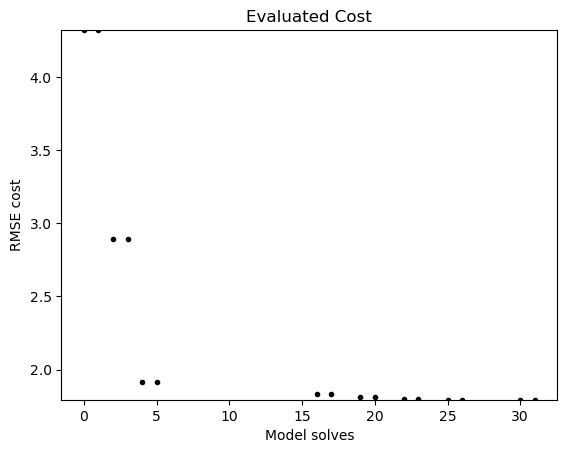

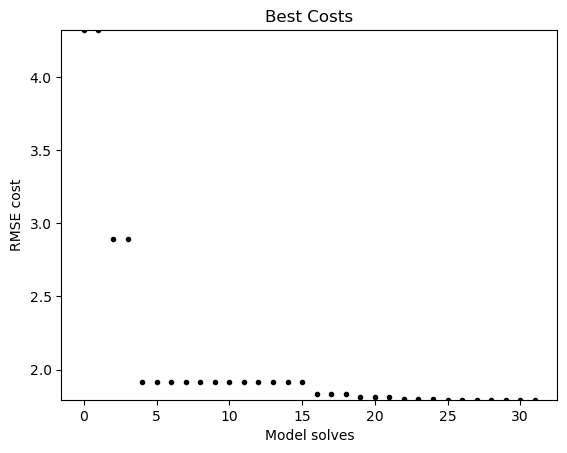

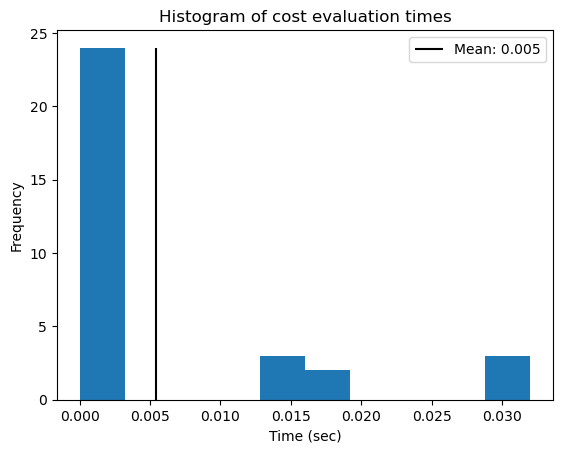

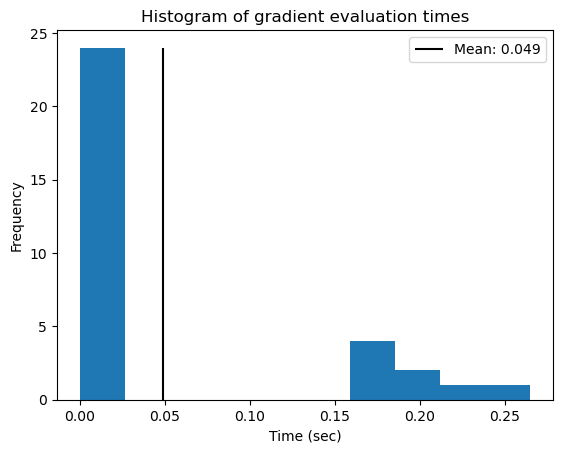

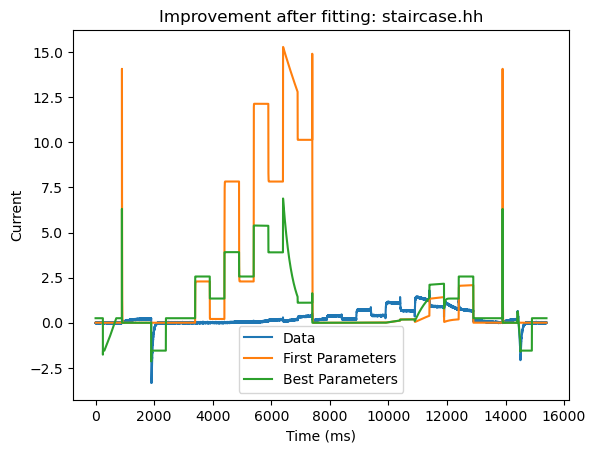

Fitted parameters are:
[6.58141203e-01 5.89344202e-03 4.81952338e-01 3.02110791e-05
 5.60329461e-06 3.16663413e-01 2.94534351e-06 1.55420266e-01
 1.09886338e-01]


In [14]:
mod = ionbench.optimisers.scipy_optimisers.trustRegionReflective_scipy.get_modification()
mod.apply(hh)
hh.reset() #Don't worry about this yet
out = ionbench.optimisers.scipy_optimisers.trustRegionReflective_scipy.run(hh, maxIter=100)
print('Fitted parameters are:')
print(out)

Once the optimisation is complete, the optimiser calls `hh.evaluate()`. This function prints the performance metrics for the best parameters as well as the performance metrics when the optimiser converged. It then plots the performance metrics over time and the model output for the first parameters, the best parameters, and the data.

These plots can be disabled by setting `hh.plotter = False`.

## Tracker
Each benchmarker stores a __Tracker__ object which calculates and stores the performance metrics over time as well as figuring out when the optimiser converged. You shouldn't normally need to interact with this __Tracker__ object, but you may wish to save the information from a __Tracker__ and store it to analyse later, for example if you are running an optimiser on an HPC and can't view the figures. You can use the __Tracker__'s `.save()` and `.load()` methods to do exactly that. 

You may have noticed the line `hh.reset()` in the previous code cell. This resets the __Tracker__ object, since otherwise all the times we called the cost function would have been included in the plots.

In [15]:
filename = 'temporary_tracker_file.pickle'
print('Number of times the model has been solved: ')
print(hh.tracker.costSolves)
hh.tracker.save(filename)
print('Number of model solves after reset:')
hh.reset()
print(hh.tracker.costSolves)
print('Number of model solves after load:')
hh.tracker.load(filename)
print(hh.tracker.costSolves)

Number of times the model has been solved: 
[1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8]
Number of model solves after reset:
[]
Number of model solves after load:
[1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8]


In [16]:
#Remove temporary file
os.remove(filename)

## Multistart
It might be useful to start an optimisation multiple times. This can be done with the multistart function. It takes inputs of an optimisers `.run` function, a benchmarker, a list of initial parameters, and a filename to use for saving the tracker information.

Additional keyword arguments, such as hyperparameters to pass into the optimiser can also be passed into the multistart function. 

The filename will be automatically appended with `'_run{i}.pickle'` where `{i}` is the index for which of the initial parameters was used for the optimisation.

Multistart will save the tracker data and printing the evaluate output (which is done whenever an optimiser is called).

We also include the `maxIters` keyword argument to ensure the optimisation doesn't run for too long. 

`ftol` termination condition is satisfied.
Function evaluations 49, initial cost 1.6263e+05, final cost 2.6809e+03, first-order optimality 2.62e+05.

===      Evaluating Performance      ===

Number of cost evaluations:      25
Number of grad evaluations:      25
Best cost:                       0.417237
Convergence reason:              Unknown optimiser specific termination.
Cost evaluations at convergence: 25
Grad evaluations at convergence: 25
Best cost at convergence:        0.417237
Model solve time at convergence: 0.875000
Grad solve time at convergence:  6.861000


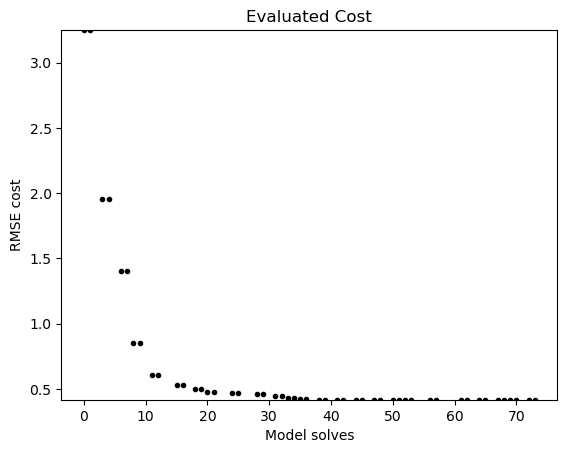

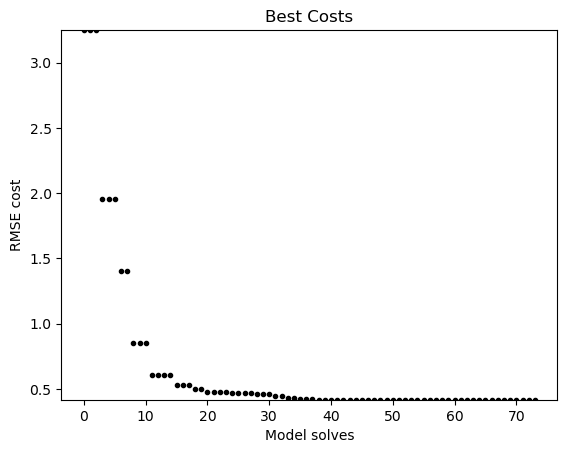

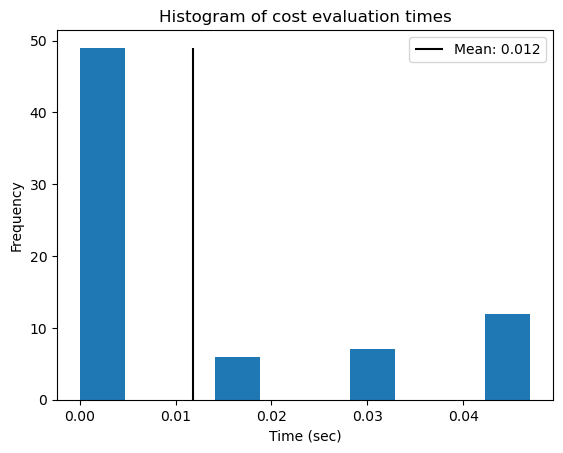

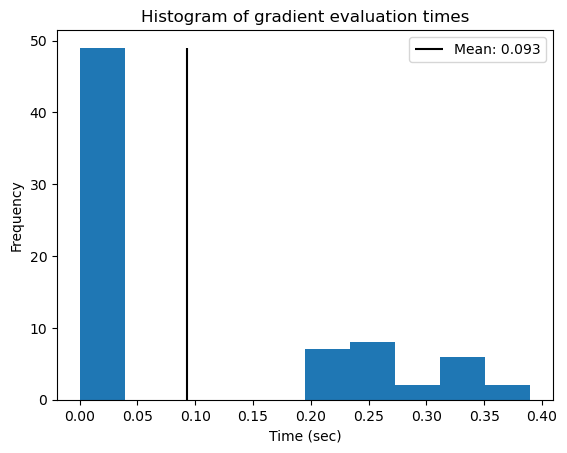

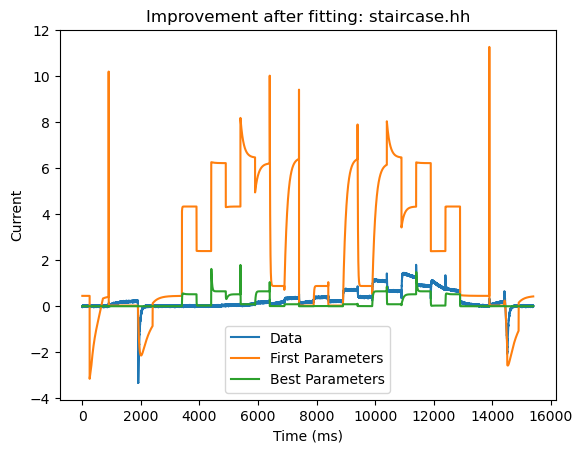

[2.58465989 0.09927133 0.01575325 0.04228588 0.43244112 0.12910107
 0.01236179 0.00603362 0.03684349]
`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 4.5843e+03, final cost 3.3961e+03, first-order optimality 1.30e+07.

===      Evaluating Performance      ===

Number of cost evaluations:      29
Number of grad evaluations:      15
Best cost:                       0.469603
Convergence reason:              Unknown optimiser specific termination.
Cost evaluations at convergence: 29
Grad evaluations at convergence: 15
Best cost at convergence:        0.469603
Model solve time at convergence: 0.891000
Grad solve time at convergence:  3.672000


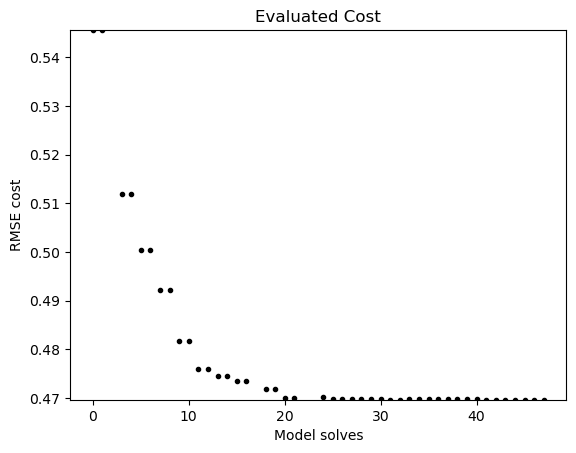

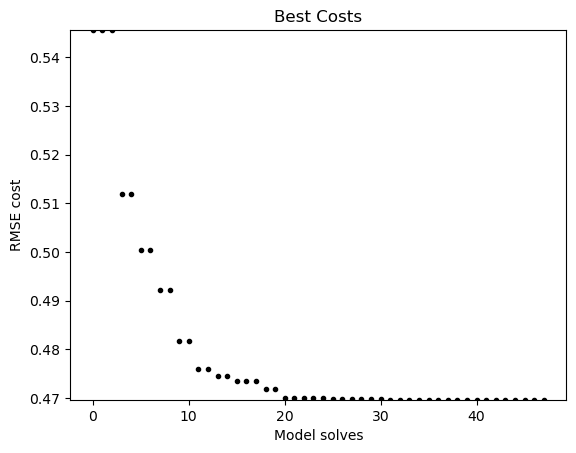

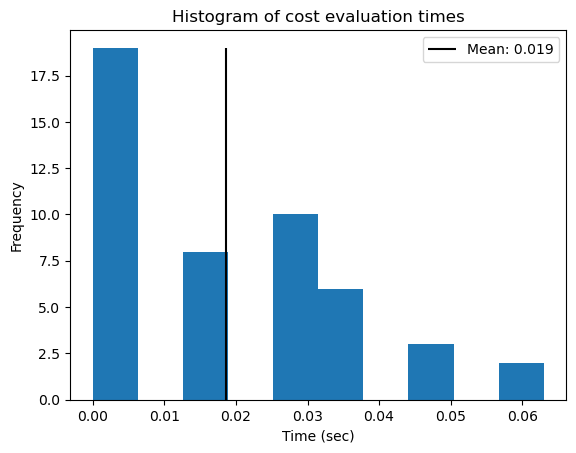

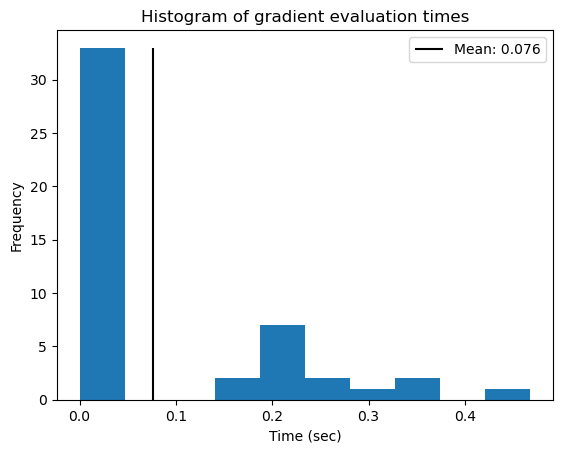

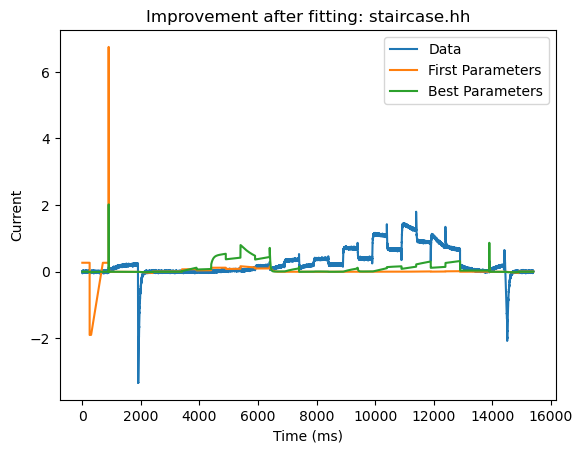

[2.38431688e-01 1.35998296e-01 1.77806970e-06 6.46100843e-02
 1.39425262e-03 1.72403017e-01 1.01495317e-04 8.02443211e-05
 3.22083230e-02]


[array([2.58465989, 0.09927133, 0.01575325, 0.04228588, 0.43244112,
        0.12910107, 0.01236179, 0.00603362, 0.03684349]),
 array([2.38431688e-01, 1.35998296e-01, 1.77806970e-06, 6.46100843e-02,
        1.39425262e-03, 1.72403017e-01, 1.01495317e-04, 8.02443211e-05,
        3.22083230e-02])]

In [17]:
opt = ionbench.optimisers.scipy_optimisers.trustRegionReflective_scipy.run
hh.reset()
initParams = hh.sample(2)
filename = 'temporary_tracker_files'
ionbench.utils.multistart(opt, hh, initParams, filename, maxIter=100)

In [18]:
os.remove(filename+'_run0.pickle')
os.remove(filename+'_run1.pickle')